(pll)=
# Phase-locked loops

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

import sdr

%config InlineBackend.print_figure_kwargs = {"facecolor" : "w"}
# %matplotlib widget
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

## Design a proportional-plus-integrator (PPI) loop filter

In [2]:
lf = sdr.LoopFilter(0.05, 1)
print(lf)

C:\Users\matth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\scipy\signal\filter_design.py:476: RuntimeWarning: divide by zero encountered in true_divide
  npp_polyval(zm1, a, tensor=False))
C:\Users\matth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\scipy\signal\filter_design.py:476: RuntimeWarning: invalid value encountered in true_divide
  npp_polyval(zm1, a, tensor=False))


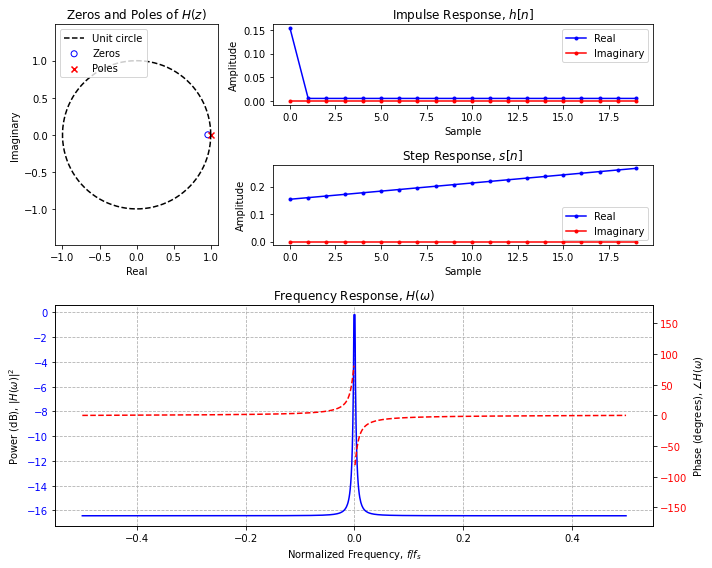

In [3]:
plt.figure(figsize=(10, 8))
lf.iir.plot_all(N_time=20)
plt.show()

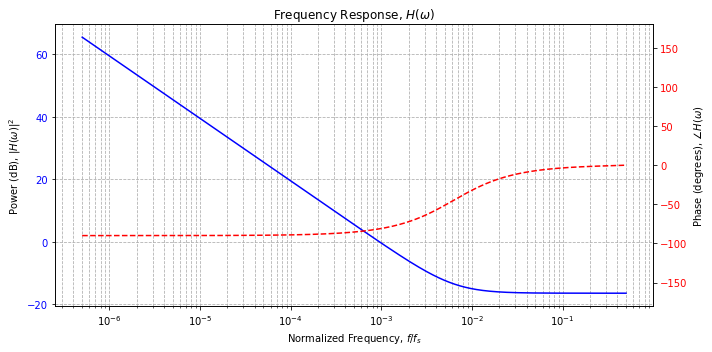

In [4]:
plt.figure(figsize=(10, 5))
lf.iir.plot_frequency_response_log(decades=6)
plt.show()

## Implement a PLL in the phase domain

This section implements Example C.2.1 from *Digital Communications: A Discrete-Time Approach*.

In [5]:
N = 75  # samples
theta_0 = 2 * np.pi / 10  # radians/sample
x = theta_0 * np.arange(N) + np.pi  # Input phase signal, radians
y = np.zeros(x.size + 1)  # Output phase signal, radians
phase_error = np.zeros(x.size)  # Measured phase error, radians
freq_estimate = np.zeros(x.size)  # Estimated frequency, radians/sample

# Create a proportional-plus-integrator (PPI) loop filter with a normalized
# noise bandwidth of 0.05 and a damping factor of 1 (critically damped)
lf = sdr.LoopFilter(0.05, 1)

# Create a numerically controlled oscillator (NCO) with NCO gain of 1
# and a constant phase accumulation of theta_0 radians/sample
nco = sdr.NCO(1, theta_0)

for i in range(N):
    # Phase error detector (PED)
    phase_error[i] = x[i] - y[i]

    # Compute the frequency estimate
    freq_estimate[i] = lf.filter(phase_error[i])

    # Process the variable phase increment through the NCO
    y[i + 1] = nco.process(freq_estimate[i])

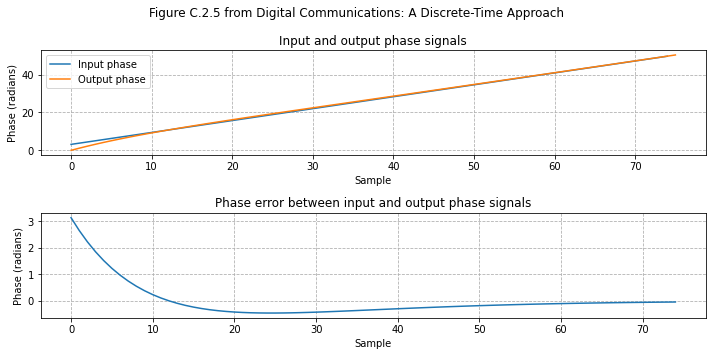

In [6]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.plot(x, label="Input phase")
plt.plot(y, label="Output phase")
plt.grid(which="both", linestyle="--")
plt.legend()
plt.xlabel("Sample")
plt.ylabel("Phase (radians)")
plt.title("Input and output phase signals")

plt.subplot(2, 1, 2)
plt.plot(phase_error)
plt.grid(which="both", linestyle="--")
plt.xlabel("Sample")
plt.ylabel("Phase (radians)")
plt.title("Phase error between input and output phase signals")

plt.suptitle("Figure C.2.5 from Digital Communications: A Discrete-Time Approach")
plt.tight_layout()
plt.show()

## Implement a PLL in the time domain

In [7]:
N = 75  # samples
theta_0 = 2 * np.pi / 10  # radians/sample
x = np.exp(1j * (theta_0 * np.arange(N) + np.pi))  # Input signal
y = np.ones(x.size + 1, dtype=np.complex64)  # Output signal
phase_error = np.zeros(x.size)
freq_estimate = np.zeros(x.size)

# Create a proportional-plus-integrator (PPI) loop filter with a normalized
# noise bandwidth of 0.05 and a damping factor of 1 (critically damped)
lf = sdr.LoopFilter(0.05, 1)

# Create a direct digital synthesizer (DDS) with NCO gain of 1
# and a constant phase accumulation of theta_0 radians/sample
dds = sdr.DDS(1, theta_0)

for i in range(N):
    # Phase error detector (PED)
    phase_error[i] = np.angle(x[i] * y[i].conj())

    # Compute the frequency estimate
    freq_estimate[i] = lf.filter(phase_error[i])

    # Process the variable phase increment through the DDS
    y[i + 1] = dds.process(freq_estimate[i])

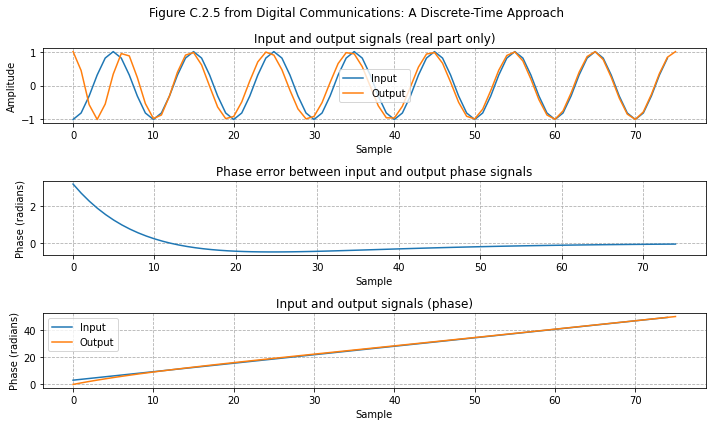

In [8]:
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(x.real, label="Input")
plt.plot(y.real, label="Output")
plt.grid(which="both", linestyle="--")
plt.legend()
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.title("Input and output signals (real part only)")

plt.subplot(3, 1, 2)
plt.plot(phase_error)
plt.grid(which="both", linestyle="--")
plt.xlabel("Sample")
plt.ylabel("Phase (radians)")
plt.title("Phase error between input and output phase signals")

plt.subplot(3, 1, 3)
plt.plot(np.unwrap(np.angle(x)), label="Input")
plt.plot(np.unwrap(np.angle(y)), label="Output")
plt.grid(which="both", linestyle="--")
plt.legend()
plt.xlabel("Sample")
plt.ylabel("Phase (radians)")
plt.title("Input and output signals (phase)")

plt.suptitle("Figure C.2.5 from Digital Communications: A Discrete-Time Approach")
plt.tight_layout()
plt.show()

## Analyze PLL closed-loop performance

In [9]:
def closed_loop_pll(K0, Kp, BnT, zeta):
    """
    Reference:
        - Equation C.51 from Digital Communications: A Discrete-Time Approach
    """
    lf = sdr.LoopFilter(BnT, zeta)
    K1 = lf.K1
    K2 = lf.K2

    b0 = 0
    b1 = Kp * K0 * (K1 + K2)
    b2 = -Kp * K0 * K1

    a0 = 1
    a1 = -2 * (1 - 0.5 * Kp * K0 * (K1 + K2))
    a2 = 1 - Kp * K0 * K1

    # Create an IIR filter that represents the closed-loop transfer function of the PLL
    pll = sdr.IIR([b0, b1, b2], [a0, a1, a2])

    omega_n = np.sqrt(K0 * Kp * K2)

    return pll, omega_n

### Compare step and frequency response across $\zeta$

C:\Users\matth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\scipy\signal\filter_design.py:1632: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


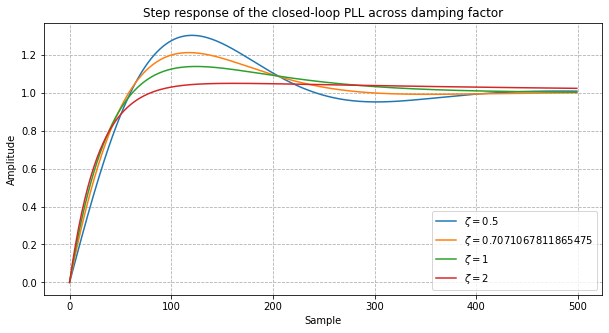

In [10]:
plt.figure(figsize=(10, 5))
for zeta in [1 / 2, 1 / np.sqrt(2), 1, 2]:
    pll, _ = closed_loop_pll(1, 1, 0.01, zeta)
    h = pll.step_response(500)
    plt.plot(h, label=rf"$\zeta = {zeta}$")
plt.grid(which="both", linestyle="--")
plt.legend()
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.title("Step response of the closed-loop PLL across damping factor")
plt.show()

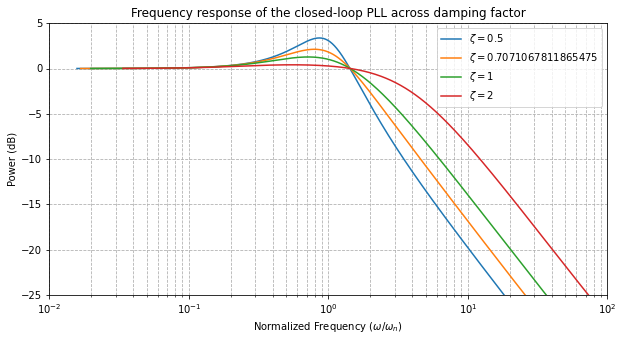

In [11]:
plt.figure(figsize=(10, 5))
for zeta in [1 / 2, 1 / np.sqrt(2), 1, 2]:
    pll, omega_n = closed_loop_pll(1, 1, 0.01, zeta)
    omega, H = pll.frequency_response_log(sample_rate=2 * np.pi)
    omega /= omega_n
    plt.semilogx(omega, 20 * np.log10(np.abs(H)), label=rf"$\zeta = {zeta}$")
plt.grid(which="both", linestyle="--")
plt.legend()
plt.xlim([10**-2, 10**2])
plt.ylim([-25, 5])
plt.xlabel(r"Normalized Frequency ($\omega / \omega_n$)")
plt.ylabel("Power (dB)")
plt.title("Frequency response of the closed-loop PLL across damping factor")
plt.show()

### Compare step and frequency response across $B_n T$

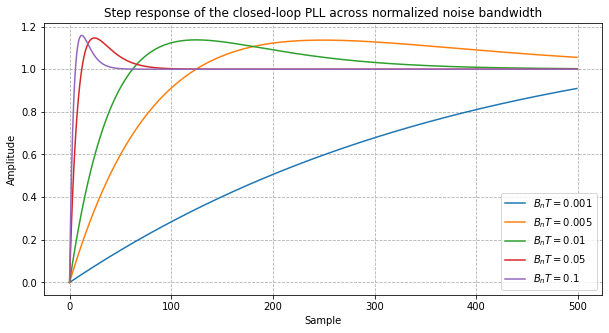

In [12]:
plt.figure(figsize=(10, 5))
for BnT in [0.001, 0.005, 0.01, 0.05, 0.1]:
    pll, _ = closed_loop_pll(1, 1, BnT, 1)
    h = pll.step_response(500)
    plt.plot(h, label=f"$B_nT = {BnT}$")
plt.grid(which="both", linestyle="--")
plt.legend()
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.title("Step response of the closed-loop PLL across normalized noise bandwidth")
plt.show()

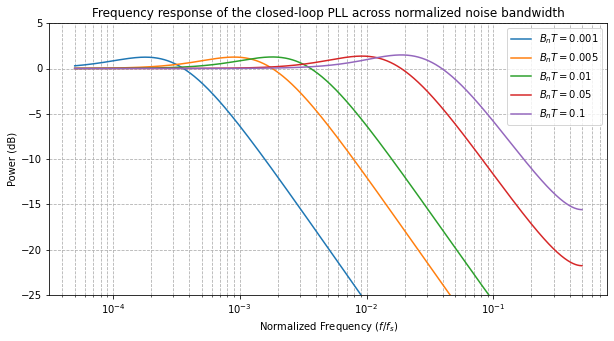

In [13]:
plt.figure(figsize=(10, 5))
for BnT in [0.001, 0.005, 0.01, 0.05, 0.1]:
    pll, _ = closed_loop_pll(1, 1, BnT, 1)
    f, H = pll.frequency_response_log(sample_rate=1)
    plt.semilogx(f, 20 * np.log10(np.abs(H)), label=f"$B_nT = {BnT}$")
plt.grid(which="both", linestyle="--")
plt.legend()
plt.ylim([-25, 5])
plt.xlabel("Normalized Frequency ($f / f_s$)")
plt.ylabel("Power (dB)")
plt.title("Frequency response of the closed-loop PLL across normalized noise bandwidth")
plt.show()